In [1]:
import matplotlib
# Temporary compatibility patch for SHAP + Matplotlib 3.9+
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get

Loaded 1653 rows, 14 columns
Train size: 1322, Test size: 331
/root/venv/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


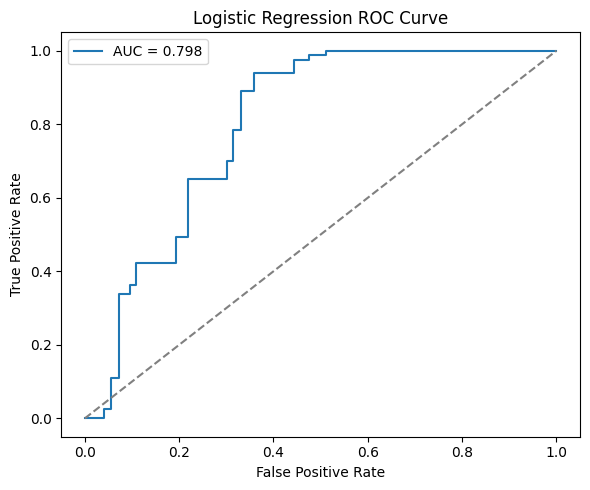

/root/venv/lib/python3.10/site-packages/mlflow/tracking/_model_registry/utils.py:215: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
Registered model 'WorkZone_LogReg' already exists. Creating a new version of this model...
Created version '8' of model 'WorkZone_LogReg'.
Logged Logistic Regression model with AUC=0.798


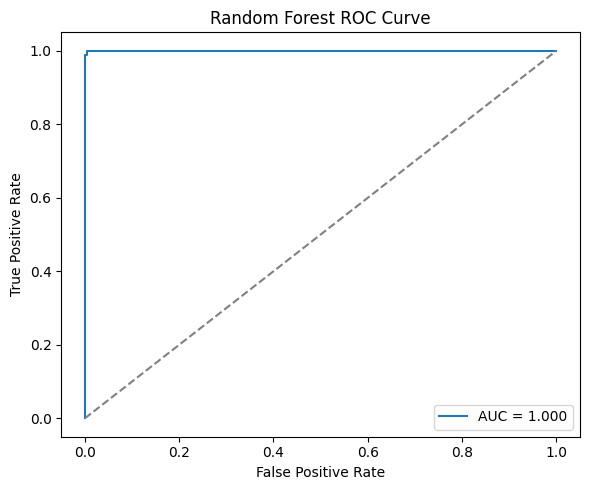

Registered model 'WorkZone_LogReg' already exists. Creating a new version of this model...
Created version '9' of model 'WorkZone_LogReg'.
Logged Random Forest model with AUC=1.000


In [2]:
#Baseline model
import os
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#Load feature dataset
DATA_PATH = "/work/siads_699_mads_capstone/data/models/workzone_features.csv"
df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} rows, {df.shape[1]} columns")

#Preprocess features
numeric_cols = ["duration_hr","avg_severity","avg_distance_km",
    "avg_visibility_mi","avg_precip_in","avg_temp_F","avg_wind_mph"]
categorical_cols = ["vehicle_impact"]

# Encode categorical variable
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
# Replace NaNs
df = df.fillna(0)
X = df[numeric_cols + categorical_cols]
y = df["high_risk"]

# Standardize numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

#MLflow tracking
mlflow.set_tracking_uri("siads_699_mads_capstone/mlruns")
mlflow.set_experiment("WorkZone_Baseline")

def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc

#Logistic regression
with mlflow.start_run(run_name="LogisticRegression_Baseline") as run:
    model_lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
    model_lr.fit(X_train, y_train)
    y_prob = model_lr.predict_proba(X_test)[:,1]
    y_pred = (y_prob > 0.5).astype(int)
    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Precision", report["1"]["precision"])
    mlflow.log_metric("Recall", report["1"]["recall"])
    mlflow.log_metric("F1", report["1"]["f1-score"])

    # Log parameters
    mlflow.log_params(model_lr.get_params())

    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Logistic Regression")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
   
    base_dir = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd()
    model_dir = os.path.join(base_dir, "siads_699_mads_capstone","data", "figures")
    os.makedirs(model_dir, exist_ok=True)
    cm_path = os.path.join(model_dir, "cm_logistic.png")
    plt.savefig(cm_path)
    #cm_path = "/work/siads_699_mads_capstone/data/figures/cm_logistic.png"
    #plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    plt.close()

    plot_roc_curve(y_test, y_prob, "Logistic Regression ROC Curve")
    #mlflow.sklearn.log_model(model_lr, "model")
    input_example = X_test[:1]
    mlflow.sklearn.log_model(
        model_lr,
        name="model",      # replaces deprecated artifact_path
        input_example=input_example,
        registered_model_name="WorkZone_LogReg"
    )
    print(f"Logged Logistic Regression model with AUC={auc:.3f}")

#Random Forest
with mlflow.start_run(run_name="RandomForest_Baseline") as run:
    model_rf = RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight="balanced", random_state=42
    )
    model_rf.fit(X_train, y_train)
    y_prob = model_rf.predict_proba(X_test)[:,1]
    y_pred = (y_prob > 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("Precision", report["1"]["precision"])
    mlflow.log_metric("Recall", report["1"]["recall"])
    mlflow.log_metric("F1", report["1"]["f1-score"])
    mlflow.log_params(model_rf.get_params())

    # Feature importance
    fi = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=fi.values, y=fi.index)
    plt.title("Random Forest Feature Importance")
    plt.tight_layout()
    #fi_path = "/work/siads_699_mads_capstone/data/figures/feature_importance_rf.png"
    fi_path = os.path.join(model_dir, "feature_importance_rf.png")
    plt.savefig(fi_path)
    mlflow.log_artifact(fi_path)
    plt.close()

    plot_roc_curve(y_test, y_prob, "Random Forest ROC Curve")
    #mlflow.sklearn.log_model(model_rf, "model")
    input_example = X_test[:1]
    mlflow.sklearn.log_model(
        model_lr,
        name="model",
        input_example=input_example,
        registered_model_name="WorkZone_LogReg"
    )
    print(f"Logged Random Forest model with AUC={auc:.3f}")


In [3]:
#AUC score=1 
set(df.iloc[y_train.index]["road_event_id"]) & set(df.iloc[y_test.index]["road_event_id"])


set()

In [4]:
#Feature dominance
importances = pd.Series(model_rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False))

avg_severity         0.295769
avg_precip_in        0.267856
avg_temp_F           0.105309
avg_distance_km      0.102228
avg_visibility_mi    0.095652
avg_wind_mph         0.086621
duration_hr          0.034014
vehicle_impact       0.012551
dtype: float64


In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
#Label leakage

X_numeric = df.select_dtypes(include=[np.number]).copy()
y = df["high_risk"]

print("Numeric feature columns:", list(X_numeric.columns))
print("Non-numeric columns dropped:", set(df.columns) - set(X_numeric.columns))

numeric_cols = [
    "duration_hr","avg_severity","avg_distance_km",
    "avg_visibility_mi","avg_precip_in","avg_temp_F",
    "avg_wind_mph","vehicle_impact"
]
X = df[numeric_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, class_weight="balanced")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring="roc_auc", method='predict_proba')
scorer = make_scorer(roc_auc_score, needs_proba=True)
scores = cross_val_score(rf, X_scaled, y, cv=cv, scoring=scorer)

print("Cross-validation AUCs:", np.round(scores, 3))
print("Mean AUC:", np.mean(scores), "Std:", np.std(scores))



Numeric feature columns: ['duration_hr', 'vehicle_impact', 'latitude', 'longitude', 'crash_count', 'avg_severity', 'avg_distance_km', 'avg_visibility_mi', 'avg_precip_in', 'avg_temp_F', 'avg_wind_mph', 'high_risk']
Non-numeric columns dropped: {'road_event_id', 'road_name'}
Cross-validation AUCs: [1.    0.999 1.    1.    1.   ]
Mean AUC: 0.9997081180933739 Std: 0.0003073934783361128


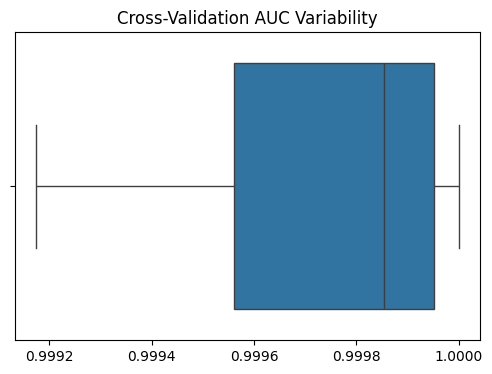

In [6]:
plt.figure(figsize=(6,4))
sns.boxplot(x=scores)
plt.title("Cross-Validation AUC Variability")
plt.show()


/root/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/root/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/root/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/root/venv/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    ret

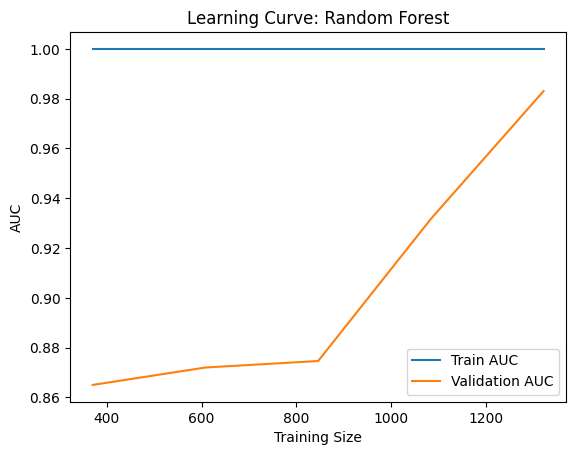

In [7]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_scaled, y, cv=5, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 6), random_state=42
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Train AUC")
plt.plot(train_sizes, np.mean(test_scores, axis=1), label="Validation AUC")
plt.xlabel("Training Size")
plt.ylabel("AUC")
plt.title("Learning Curve: Random Forest")
plt.legend()
plt.show()


In [8]:
from scipy.stats import pointbiserialr

for col in X_numeric.columns:
    if col != "high_risk":
        r, p = pointbiserialr(y, X_numeric[col])
        print(f"{col:20s} r={r:.3f}, p={p:.3e}")


duration_hr          r=-0.021, p=3.858e-01
vehicle_impact       r=-0.028, p=2.516e-01
latitude             r=-0.145, p=3.004e-09
longitude            r=0.140, p=1.002e-08
crash_count          r=0.789, p=0.000e+00
avg_severity         r=-0.077, p=1.843e-03
avg_distance_km      r=0.092, p=1.699e-04
avg_visibility_mi    r=0.146, p=2.710e-09
avg_precip_in        r=0.201, p=1.668e-16
avg_temp_F           r=0.158, p=1.110e-10
avg_wind_mph         r=0.187, p=1.558e-14


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=609edc76-98cb-4265-b05f-b8bb14bd7d7b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>